In [9]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, sqlite3, pickle, time, datetime

# 0 Loading Data 

In [10]:
t = time.time()
path  = r'/rfs/CAPAI_PhD_dflr2/dflr2/Codes_Data_2/Data/'
#file1 = path + '20210525_admissions.txt' 
#file2 = path + '20210525_eobs.txt'
file3 = path + '20210525_haem-results.txt'
#file4 = path + '20210525_icu.txt'
file5 = path + '20210525_meds.txt'
file6 = path + '20210525_micro-results.txt'
file7 = path + '20210525_oxygen.txt'
file8 = path + '20210525_prev_admissions.txt'
file9 = path + '20210525_spin.txt'
#df_admin = pd.read_csv(file1, sep='\t', lineterminator='\n')
#df_eobs  = pd.read_csv(file2, sep='\t', lineterminator='\n')
df_haemt = pd.read_csv(file3, sep='\t', lineterminator='\n')
#df_icu   = pd.read_csv(file4, sep='\t', lineterminator='\n')
df_meds  = pd.read_csv(file5, sep='\t', lineterminator='\n')
df_micro = pd.read_csv(file6, sep='\t', lineterminator='\n')
#df_oxyge = pd.read_csv(file7, sep='\t', lineterminator='\n')
#df_prev  = pd.read_csv(file8, sep='\t', lineterminator='\n')
df_spin  = pd.read_csv(file9, sep='\t', lineterminator='\n')######

/local/dlr10/ipykernel_17392/2938015234.py:17: DtypeWarning: Columns (10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_micro = pd.read_csv(file6, sep='\t', lineterminator='\n')


In [11]:
##############################################################################
#######################################
### Relevant fields for pre-processing
#######################################
reference_date = datetime.datetime(1970,1,1)

##### Fields in table patients ##########
patient_field         = 'patient_id'
age_field             = 'age_at_admission\r'
sex_field             = 'sex'
ethnic_field          = 'ethnic_origin'
death_ind_field       = 'death_indicator'
death_date_field      = 'date_of_death'
death_date_code_field = 'date_code_of_death'
mort_in_hosp_field    = 'Thirty_day_mort'
patients_cols = [patient_field,sex_field, ethnic_field, death_ind_field, death_date_field, death_date_code_field, 
                 mort_in_hosp_field]

##### Fields in table admissions ########
admission_field           = 'admission_id'
diagnosis_field           = 'episode_diagnoses'
admn_date_field           = 'admission_date_time'
admn_discharge_field      = 'discharge_date_time'
admn_date_code_field      = 'admission_date_code_time'
admn_discharge_code_field = 'discharge_date_code_time'
lengthofstay_field        = 'lengthofstay'
isPneumonia_field         = 'isPneumonia'
mortal_admin_field        = 'mortal_admin'
comorbidity_field         = 'Comorbidity_score'
icu_admin_field           = 'icu_count\r'
no_eobs_field             = 'no_obs_eobs'
no_haematology_field      = 'no_haematology_eobs'

 ##### Fields in table eObservations #####
eObs_time_field      = 'timestamp'
eObs_time_code_field = 'timestamp_code'
eObs_time_prev_obs   = 'time_since_prev_obs_in_mins'
eObs_resprate_field  = 'rr'
eObs_sbp_field       = 'sbp'
eObs_dbp_field       = 'dbp'
eObs_newscore_field  = 'ews'
eObs_heartrate_field = 'heart_rate'
eObs_temptr_field    = 'temperature\r'
eObs_oxygen_field    = 'Oxygen_Saturation'

##### Fields in table haematological tests #####
test_code_field      = 'local_test_code'
test_time_field      = 'sample_collection_date_time'
test_time_code_field = 'sample_collection_date_code_time'
haemt_cols = [test_code_field, test_time_field, test_time_code_field]

In [12]:
#########################################################
# FORMATTING FIELD IN HAEMATOLOGY
#########################################################
t = time.time()
df_haemt = df_haemt.rename(columns = {'system_number':  'patient_id' })
df_haemt[test_time_field]      = pd.to_datetime(df_haemt[test_time_field], format='%Y-%m-%d %H:%M:%S')
df_haemt[test_time_code_field] = df_haemt[test_time_field] - reference_date
df_haemt[test_time_code_field] = df_haemt[test_time_code_field].apply(lambda x: x.days + (x.seconds/(24*3600)))
print("time elapsed: ", time.time() - t)

time elapsed:  185.8358292579651


In [13]:
#########################################################
# LOAD PREPROCESSED DF_PATIENTS, DF_ADMISSIONS 
#########################################################
data = pickle.load( open(r'DataFrame_pickles/df_patients_admissions_2016_2018_v2.pickle', 'rb'))
df_patients   = data[0]
df_admissions = data[1]

# 1. EXPLORING RAW HAEMATOLOGY DATA

In [14]:
len(df_haemt['local_test_code'].unique())

1265

# df_haemt.head(5)

In [15]:
display(df_haemt[df_haemt['local_test_code']=='CREA'].head(4))

,patient_id,sample_collection_date_time,local_test_code,result,result_expansion,refererence_range,units,specimen_type\r,sample_collection_date_code_time
7,21810375,2017-01-23 08:20:00,CREA,56,56,60{120,umol/L,Serum\r,17189.347222
110,86138840,2017-01-23 08:40:00,CREA,167,167,60{120,umol/L,Serum\r,17189.361111
168,14685758,2016-11-09 09:39:00,CREA,118,118,60{120,umol/L,Serum\r,17114.402083
170,52614684,2016-11-09 09:21:00,CREA,85,85,60{120,umol/L,Serum\r,17114.389583


In [3]:
import csv
#with open('blood_test.csv', 'w') as f: 
#    write = csv.writer(f) 
#    write.writerow(df_haemt['local_test_code'].unique().tolist()) 

### 1.1.Remove HAEMATOLOGY null's tests and duplicates

In [9]:
t = time.time()

print("Tests in heamatology", len(df_haemt))
df_haematology = df_haemt[df_haemt[patient_field].isin(df_patients[patient_field].unique().tolist())]
print("Test in heamatology of patients that have eObs too: ", len(df_haematology))
print("")
print('Number of Haem records with Local test nan:', len(df_haematology[df_haematology['local_test_code'].isnull()]))
df_haematology = df_haematology.drop(df_haematology[df_haematology['local_test_code'].isnull()].index, axis = 0)
print("Number of Haem records adter dropping nan's values test:", len(df_haematology))
# Remove duplicates
df_haematology = df_haematology.drop_duplicates(keep = 'first')
print("")
print("Heamatology samples after removing duplicates: ", len(df_haematology))
print("")
print("elapsed",time.time()-t)

Tests in heamatology 18000173
Test in heamatology of patients that have eObs too:  15226015

Number of Haem records with Local test nan: 598614
Number of Haem records adter dropping nan's values test: 14627401

Heamatology samples after removing duplicates:  14622439

elapsed 36.66820430755615


### 1.2. Rearrange df_haematology: Assign admission and filtering information from admissions needed

In [10]:
t = time.time()
df_haematology_new = pd.DataFrame(columns = df_haemt.columns)
df_haematology_new[admission_field ] = 0

patients_in_haemt = df_haematology[patient_field].unique().tolist()
t = time.time()
for pat in patients_in_haemt:
    pat_admissions = df_admissions[df_admissions[patient_field] == pat][admission_field].tolist()
    
    for pat_admin in pat_admissions:
        min_admin_date = df_admissions[(df_admissions[patient_field] == pat) & (df_admissions[admission_field]== pat_admin)][admn_date_code_field].min()
        max_admin_date = df_admissions[(df_admissions[patient_field] == pat) & (df_admissions[admission_field]== pat_admin)][admn_discharge_code_field].max()
        temp = df_haematology[(df_haematology[patient_field] == pat) 
                              & (df_haematology[test_time_code_field] >= int(min_admin_date) - 1) 
                              & (df_haematology[test_time_code_field] <= int(max_admin_date) + 1)].sort_values(by=test_time_field)
        temp[admission_field] = pat_admin
        df_haematology_new = pd.concat([df_haematology_new,temp]) if len(temp) > 0 else df_haematology_new
    
print("elapsed",time.time()-t)

elapsed 8036.518485069275


In [11]:
print("number of records before filtering", len(df_haematology))
print("number of records after filtering", len(df_haematology_new))

number of records before filtering 14622439
number of records after filtering 3333269


In [12]:
df_haematology_new.head()

,patient_id,sample_collection_date_time,local_test_code,result,result_expansion,refererence_range,units,specimen_type\r,sample_collection_date_code_time,admission_id
438848,87449365,2018-04-08 15:54:00,BLAST,0.00,0.00,NaN,x10^9/l,Serum\r,17629.6625,30861976
4021034,87449365,2018-04-08 15:54:00,ALB,36,36,35{50,g/l,Serum\r,17629.6625,30861976
438983,87449365,2018-04-08 15:54:00,BASO,0.00,0.00,0.02{0.10,x10^9/L,Serum\r,17629.6625,30861976
502794,87449365,2018-04-08 15:54:00,META,0.00,0.00,NaN,x10^9/l,Serum\r,17629.6625,30861976
4176418,87449365,2018-04-08 15:54:00,MONO,0.24,0.24,0.2{0.8,x10^9/l,Serum\r,17629.6625,30861976


# 2. Pickle df_haematology_V0

In [13]:
pickling_data = [df_haematology_new]
pickle.dump(pickling_data, open('DataFrame_pickles/df_haematology_v0_1.pickle', 'wb'))

# 3. Load Pickle df_haematology_v0

In [16]:
df_pikcled_data = pickle.load( open('DataFrame_pickles/df_haematology_v0_1.pickle', 'rb')) 
df_haematology_new = df_pikcled_data[0]
display(df_haematology_new.head(5) )

,patient_id,sample_collection_date_time,local_test_code,result,result_expansion,refererence_range,units,specimen_type\r,sample_collection_date_code_time,admission_id
438848,87449365,2018-04-08 15:54:00,BLAST,0.00,0.00,NaN,x10^9/l,Serum\r,17629.6625,30861976
4021034,87449365,2018-04-08 15:54:00,ALB,36,36,35{50,g/l,Serum\r,17629.6625,30861976
438983,87449365,2018-04-08 15:54:00,BASO,0.00,0.00,0.02{0.10,x10^9/L,Serum\r,17629.6625,30861976
502794,87449365,2018-04-08 15:54:00,META,0.00,0.00,NaN,x10^9/l,Serum\r,17629.6625,30861976
4176418,87449365,2018-04-08 15:54:00,MONO,0.24,0.24,0.2{0.8,x10^9/l,Serum\r,17629.6625,30861976


In [17]:
t = time.time()
#####################################################################
#Extraction of blood codes frequencies per patient and admissions
#####################################################################
df_blood_codes = df_haematology_new[test_code_field].value_counts()
aa = []
for i,x in enumerate(np.array(df_blood_codes)): 
    if np.array(df_blood_codes)[:i].sum() < 0.95 * len(df_haematology_new): aa.append(x)
df_blood_codes = df_blood_codes[:len(aa)]
df_blood_codes = df_blood_codes.to_frame()

df_blood_codes['no_patients']   = [len(df_haematology_new[df_haematology_new[test_code_field] == code][patient_field].unique().tolist()) for code in df_blood_codes.index]
df_blood_codes['no_admissions'] = [len(df_haematology_new[df_haematology_new[test_code_field] == code][admission_field].unique().tolist()) for code in df_blood_codes.index]

A = df_blood_codes.index.tolist()

print("Number of tests to consider")
print(len(df_blood_codes))
display(df_blood_codes.head(50))
print("elapsed",time.time()-t)

Number of tests to consider
34


,local_test_code,no_patients,no_admissions
CREA,131462,14898,18458
UREA,131436,14898,18458
K,131222,14898,18458
GFR,130244,14869,18424
WBC,127278,14897,18456
AKIDUM,126097,14875,18419
RBC,123702,14891,18445
PLT,123701,14891,18445
HCT,123701,14891,18445
HGB,123694,14891,18445


elapsed 21.74949359893799


In [18]:
len(df_blood_codes)

34

# 4. Process Haematology respect to eObs


### Load eobs table 

In [19]:
path = r'DataFrame_pickles/df_eobs_3d.pickle'
df_eobs = pickle.load( open(path, 'rb'))

list_admissions_eobs = df_eobs[admission_field].unique().tolist()
print("Number of admissions in eObs:",len(list_admissions_eobs))

Number of admissions in eObs: 13950


### 4.1. Filter admissions that are in haematology and eobs

In [20]:
df_haematology_new  = df_haematology_new[df_haematology_new[test_code_field].isin(df_blood_codes.index)]
df_haematology_new  = df_haematology_new[df_haematology_new[admission_field].isin(list_admissions_eobs)]
blood_admissions    = df_haematology_new[admission_field].unique().tolist()
test_result_field    = 'result'

In [21]:
print("Number of admissions in df_Haematology:",len(blood_admissions))

Number of admissions in df_Haematology: 13931


### 4.2. Rearrange df_Haematology to Test in columns, and rows records in admission

In [22]:
t = time.time()
DF_df = []
for i, admin in enumerate(blood_admissions):   
    t2 = time.time()
    temp = df_haematology_new[df_haematology_new[admission_field] == admin]
    temp_times_codes = temp[test_time_code_field].unique().tolist()    
    for date_time_code in temp_times_codes:
        DF = [] 
        DF.append(temp.iloc[0][admission_field])
        temp2 = temp[temp[test_time_code_field]==date_time_code]
        DF.append(temp2.iloc[0][test_time_field])
        DF.append(date_time_code)
        for code in df_blood_codes.index:            
            if code in temp2[test_code_field].tolist():
                DF.append(temp2[temp2[test_code_field] == code].iloc[0][test_result_field])
            else:
                DF.append(np.nan)
        DF_df.append(DF)
    
    if i % 1000 == 0: print(i,str(datetime.datetime.today()), time.time()- t2)   
    
cols_Haem          = [admission_field,test_time_field, test_time_code_field ] + df_blood_codes.index.tolist()
df_haematology_new = pd.DataFrame(DF_df, columns  = cols_Haem)
print("elapsed",time.time()-t)

0 2023-06-13 11:56:12.014759 0.15595245361328125
1000 2023-06-13 11:58:40.947097 0.04562568664550781
2000 2023-06-13 12:01:00.020957 0.05167961120605469
3000 2023-06-13 12:03:11.449758 0.03647494316101074
4000 2023-06-13 12:05:11.267096 0.1690654754638672
5000 2023-06-13 12:06:53.268528 0.11945772171020508
6000 2023-06-13 12:08:36.721540 0.05950021743774414
7000 2023-06-13 12:10:18.813616 0.11197257041931152
8000 2023-06-13 12:11:46.901325 0.030954837799072266
9000 2023-06-13 12:13:07.718026 0.03219342231750488
10000 2023-06-13 12:14:36.581975 0.05118513107299805
11000 2023-06-13 12:16:06.574388 0.07815051078796387
12000 2023-06-13 12:17:29.464370 0.03870511054992676
13000 2023-06-13 12:18:52.429305 0.04166412353515625
elapsed 1450.376618862152


### 4.3. Removing strange characters

In [23]:
t = time.time()
def processing_haematology(x):
    if type(x) == str and ('>' in x or '<' in x):
        a = 0.0015
        x_ = float(re.sub(r'[>|<]', '',x))
        if '>' == x[0]:
            x_ = x_ + a
        elif '<' == x[0]:
            x_ = x_ - a
    elif (type(x) == str and x[0].isnumeric() and x[-1].isnumeric()) or (type(x) == int or type(x) == float):
        x_ = float(x)
    else:
        x_ = np.nan
    return x_

df_haematology_new_v2 = pd.DataFrame(df_haematology_new.loc[:,[admission_field, test_time_field, test_time_code_field]])
haem_cols             = df_haematology_new.columns.tolist()[3:]
feature = haem_cols[0]

for feature in haem_cols :
    df_haematology_new_v2.loc[:,feature] = df_haematology_new[feature].apply(lambda x: processing_haematology(x))
print("elapsed",time.time()-t)

elapsed 3.4422621726989746


In [24]:
print("Length df_haematology", len(df_haematology_new))
df_haematology_new.head(5)

Length df_haematology 126048


,admission_id,sample_collection_date_time,sample_collection_date_code_time,CREA,UREA,K,GFR,WBC,AKIDUM,RBC,...,ACA,INR,PT,APTTR,APTT,MG,EGFR,FIB,AMY,CL
0,30861976,2018-04-08 15:54:00,17629.662500,67,11.8,4.0,78,12.0,0,3.27,...,2.11,1.4,16.3,1.3,38.2,0.70,NaN,NaN,19,NaN
1,30861976,2018-04-09 06:54:00,17630.287500,46,15.1,4.3,>90,14.5,0,5.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30861976,2018-04-10 09:08:00,17631.380556,34,12.9,4.0,>90,18.5,0,4.61,...,2.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30861976,2018-04-11 09:12:00,17632.383333,25,8.4,3.6,>90,21.6,0,4.31,...,1.98,1.2,14.5,1.6,45.6,NaN,NaN,NaN,NaN,NaN
4,30861976,2018-04-13 09:35:00,17634.399306,26,6.1,4.0,>90,10.2,0,5.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 5. Handling Outliers

In [33]:
adms_plot_dict = {'CREA':[60815638, 79878900, 4736282, 29465887],  #check
'UREA':[80761448, 33438688, 58912774, 20570332], #check
'K':[51032292, 54254735, 89005953, 27673201], #check
'EGFR':[],
'GFR':[64582871, 30771748, 10326701, 84630742], #check
'WBC':[8695172, 3763396, 65046067, 91351161], #check
'PLT':[69349024, 69442642, 24300254, 18049984], # check
'HCT':[80496263, 60780276, 90966714, 96858934], # check
'HGB':[38716719, 70067262, 68786852, 48587355], # check
'RBC':[44935076, 95257832, 15466604, 80496263], # check
'MCH':[76683693, 75334695, 81499935, 35832372], # check
'MCV':[82250688, 65114235, 4362470, 66444072], #check
'NEUAB':[58481475, 76887082, 22753988, 15945935], #check
'TLYMAB':[85127829, 98534596, 17822553, 67724105], #check
'EOSAB':[52531383, 69442642, 29577642, 25464596],
'MONAB':[56418966, 76558517, 7311186, 42120674], # check
'BASAB':[36719940, 63797298, 16503656, 23315539], #check
'ALB':[39862404, 91856702, 17781808, 61680560], # check
'ALP':[33887209, 47604654, 47604654, 63675992], #check
'BILI':[19776463, 38405102, 29734845, 90041857]} # 39074597

In [38]:
import random
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.pyplot as plt

def handling_errors(field, df_eobs_new,dict_sypmt_min_max, save = False):
    n_plots = 4
    print(field)
    print("Values na in " + field,df_eobs_new[field].isna().sum())
    min_b = dict_sypmt_min_max[field][0]
    max_b = dict_sypmt_min_max[field][1]
    adm_withmin = df_eobs_new[min_b > df_eobs_new[field]]['admission_id'].unique().tolist()
    adm_withmax = df_eobs_new[df_eobs_new[field] > max_b]['admission_id'].unique().tolist()
    adms_plot   = adm_withmin + adm_withmax
    
    field_max = df_eobs_new[field].max()
    n_outliers = len(df_eobs_new[(min_b > df_eobs_new[field]) | (df_eobs_new[field] > max_b)])
    
    print('Number of admissions that will change:', len(adms_plot) )    
    print('Number of records out of limits:', n_outliers)
    df_eobs_new2 = df_eobs_new.copy()
    df_eobs_new2[field] = df_eobs_new2[field].apply(lambda x: np.nan if x!=x else x if (min_b <= x) and (x <= max_b) 
                                                    else min_b if x < min_b else max_b)
    n_outliers2 = len(df_eobs_new2[(min_b > df_eobs_new2[field]) | (df_eobs_new2[field] > max_b)])
    
    print("Percentage of admins modified for " + field, "from", len(df_eobs_new2['admission_id'].unique()), 
          "is {:0.2f}".format(len(adms_plot)*100/len(df_eobs_new2['admission_id'].unique())), "%")
    print("Percentage of records modified for " + field, "from", len(df_eobs_new2), 
          "is {:0.2f}".format(n_outliers*100/len(df_eobs_new2)), "%")
    
    lim_plot_dict = {'CREA':650, 'UREA':50,'K':15,'EGFR':150,'GFR': 75,'WBC':60, 'PLT':850,'HCT':1,'HGB':230,
                  'RBC':9,'MCH':50,'MCV': 125, 'NEUAB': 30,'TLYMAB':10,'EOSAB':4,'MONAB':2.8,'BASAB':0.75,'ALB':80,
                  'ALP':420,'BILI':150}
    lim_low_dict = {'CREA':15, 'UREA':-1,'K':0,'EGFR':0,'GFR': 0,'WBC':-1, 'PLT':50,'HCT':0,'HGB':40,
                  'RBC':0,'MCH':10,'MCV': 40, 'NEUAB': -1,'TLYMAB':-1,'EOSAB':-0.,'MONAB':-0.5,'BASAB':-0.3,'ALB':5,
                  'ALP':0,'BILI':0}
    fig = plt.figure(figsize = (25,5))

    for i,adm_ in enumerate(adms_plot_dict[field]):
        #adm_ = adms_plot[idx_adm]    
        x = df_eobs_new[df_eobs_new[admission_field] == adm_]['sample_collection_date_time'].tolist()
        x1 = np.arange(0, len(x), 1)
        y = df_eobs_new[df_eobs_new[admission_field] == adm_][field]

        xt = df_eobs_new2[df_eobs_new2[admission_field] == adm_]['sample_collection_date_time']
        xt1 = np.arange(0, len(xt), 1)
        yt = df_eobs_new2[df_eobs_new2[admission_field] == adm_][field]

        ax = fig.add_subplot(1, n_plots, i+1)
        ax.plot(x1,y, 'b-.', label = 'Original')
        ax.plot(xt1,yt, 'r-', label = 'Processed')
        
        ax.plot(x1, np.ones(len(x1)) * max_b, '--', color = 'orange')
        ax.plot(x1, np.ones(len(x1)) * min_b, '--', color = 'orange')
        
        ax.tick_params(labelsize =22)
        ax.set_ylim((lim_low_dict[field], lim_plot_dict[field]))
        ax.set_title('admission ' + str(adm_), fontsize = 25)
        
   
        
    fig.text(0.08, 0.5, dict_labels[field], va='center', rotation='vertical', fontsize = 30)
    if field == 'CREA':
        plt.legend(fontsize = 20, loc = 'lower right', frameon=False, framealpha = 0.4)
    else:
        plt.legend(fontsize = 20, loc = 'upper right', frameon=False, framealpha = 0.4)
    if save == True: 
        plt.savefig(r'Images/Train_HandlingOutliersExample_'+ field +'.png', transparent = True, bbox_inches = "tight")
    plt.show()
    return df_eobs_new2

import random
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.pyplot as plt

def handling_errors(field, df_eobs_new,dict_sypmt_min_max, save = False):
    n_plots = 4
    print(field)
    print("Values na in " + field,df_eobs_new[field].isna().sum())
    min_b = dict_sypmt_min_max[field][0]
    max_b = dict_sypmt_min_max[field][1]
    adm_withmin = df_eobs_new[min_b > df_eobs_new[field]]['admission_id'].unique().tolist()
    adm_withmax = df_eobs_new[df_eobs_new[field] > max_b]['admission_id'].unique().tolist()
    adms_plot   = adm_withmin + adm_withmax
    
    field_max = df_eobs_new[field].max()
    n_outliers = len(df_eobs_new[(min_b > df_eobs_new[field]) | (df_eobs_new[field] > max_b)])
    
    
    print('Number of admissions that will change:', len(adms_plot) )    
    print('Number of records out of limits:', n_outliers)
    
    if len(adms_plot) == 0 : 
        print("No values to fix")
        return df_eobs_new
    if len(adms_plot) <= n_plots: adm_idxs    = range(len(adms_plot))
    else:                   adm_idxs    = random.sample(range(len(adms_plot)), n_plots)

    df_eobs_new2 = df_eobs_new.copy()
    df_eobs_new2[field] = df_eobs_new2[field].apply(lambda x: np.nan if x!=x else x if (min_b <= x) and (x <= max_b) 
                                                    else min_b if x < min_b else max_b)
    n_outliers2 = len(df_eobs_new2[(min_b > df_eobs_new2[field]) | (df_eobs_new2[field] > max_b)])
    
    print("Percentage of admins modified for " + field, "from", len(df_eobs_new2['admission_id'].unique()), 
          "is {:0.2f}".format(len(adms_plot)*100/len(df_eobs_new2['admission_id'].unique())), "%")
    print("Percentage of records modified for " + field, "from", len(df_eobs_new2), 
          "is {:0.2f}".format(n_outliers*100/len(df_eobs_new2)), "%")
    
    lim_plot_dict = {'CREA':650, 'UREA':50,'K':15,'EGFR':150,'GFR': 75,'WBC':60, 'PLT':850,'HCT':1,'HGB':230,
                  'RBC':9,'MCH':50,'MCV': 125, 'NEUAB': 30,'TLYMAB':10,'EOSAB':4,'MONAB':2.8,'BASAB':0.75,'ALB':80,
                  'ALP':420,'BILI':150}
    lim_low_dict = {'CREA':15, 'UREA':-1,'K':0,'EGFR':0,'GFR': 0,'WBC':-1, 'PLT':50,'HCT':0,'HGB':40,
                  'RBC':0,'MCH':10,'MCV': 40, 'NEUAB': -1,'TLYMAB':-1,'EOSAB':-0.,'MONAB':-0.5,'BASAB':-0.3,'ALB':5,
                  'ALP':0,'BILI':0}
    fig = plt.figure(figsize = (25,5))

    for i,idx_adm in enumerate(adm_idxs):
        adm_ = adms_plot[idx_adm]    
        x = df_eobs_new[df_eobs_new[admission_field] == adm_]['sample_collection_date_time'].tolist()
        x1 = np.arange(0, len(x), 1)
        y = df_eobs_new[df_eobs_new[admission_field] == adm_][field]

        xt = df_eobs_new2[df_eobs_new2[admission_field] == adm_]['sample_collection_date_time']
        xt1 = np.arange(0, len(xt), 1)
        yt = df_eobs_new2[df_eobs_new2[admission_field] == adm_][field]

        ax = fig.add_subplot(1, n_plots, i+1)
        ax.plot(x1,y, 'b-.', label = 'Original')
        ax.plot(xt1,yt, 'r-', label = 'Processed')
        
        ax.plot(x1, np.ones(len(x1)) * max_b, '--', color = 'orange')
        ax.plot(x1, np.ones(len(x1)) * min_b, '--', color = 'orange')
        
        ax.tick_params(labelsize =22)
        ax.set_ylim((lim_low_dict[field], lim_plot_dict[field]))
        ax.set_title('admission ' + str(adm_), fontsize = 25)
        
   
        
    fig.text(0.08, 0.5, dict_labels[field], va='center', rotation='vertical', fontsize = 30)
    plt.legend(fontsize = 20, loc = 'upper right', frameon=False, framealpha = 0.4)
    if save == True: 
        plt.savefig(r'Images/Train_HandlingOutliersExample_'+ field +'.png', transparent = True, bbox_inches = "tight")
    plt.show()
    return df_eobs_new2

In [39]:
df_haematology_new_v2.describe().to_csv('bloot_test_description.csv')

In [42]:
dict_labels = {'rr':'Respiratory rate','ews':'EWS','heart_rate':'Heart rate','temperature\r':'Temperature',
               'sbp':'Systolic bp','dbp':'Diastolic bp','Oxygen_Saturation':'Oxygen Saturation','Assisted_O2':'Assisted O2',
               'Confusion':'Confusion','CREA':'Creatinine','UREA':'Urea','K':'Potassium', 'GFR':'GFR', 'EGFR':'GFR','WBC':'WBC',
               'PLT':'Platelets','HCT':'HCT','HGB':'Haemoglobin','RBC':'RBC','MCH':'MCH','MCV':'MCV','NEUAB':'Neutrophil Ab',
               'TLYMAB':'T-lymphocite Ab','EOSAB':'EOS Ab','MONAB':'Monocyte Ab','BASAB':'Anti Basophil Ab','ALB':'Albumin',
               'ALP':'Alk. Phosphate','BILI':'Bilirubin','sex':'Sex','ethnicity':'Ethnicity','had_Prev_admin':'Prev. admission',
               'age_at_admin':'Age at admission','Comorb_score':'Charlson comorbid.','Spcfc_Comorb':'Resp. Comorbidity'}


dict_blood_min_max = {'CREA':[20, 600], 'UREA':[0.5, 30],'K':[2,7],'EGFR':[20,200],'GFR':[20, 200],'WBC':[3, 55],
         'PLT':[90, 800],'HCT':[0.2, 0.75],'HGB':[70,200],'RBC':[2, 7],'MCH':[20, 42],'MCV':[70, 120],
         'NEUAB':[0.5, 20],'TLYMAB':[0.3,7],'EOSAB':[0, 1.6],'MONAB':[0.005,2.5],'BASAB':[0,0.5],'ALB':[20, 70],
         'ALP':[30,400],'BILI':[0, 50]}


CREA
Values na in CREA 8113
Number of admissions that will change: 331
Number of records out of limits: 2295
Percentage of admins modified for CREA from 13931 is 2.38 %
Percentage of records modified for CREA from 126048 is 1.82 %


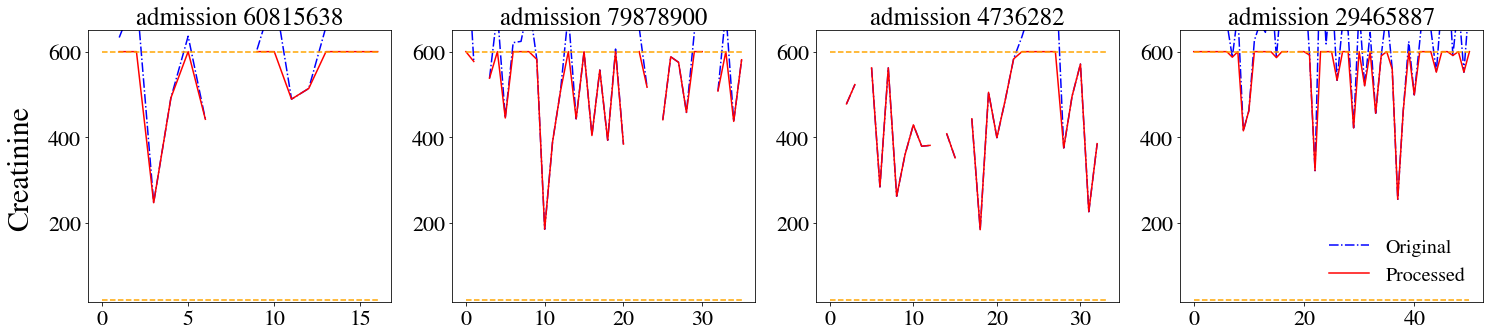

UREA
Values na in UREA 8133
Number of admissions that will change: 748
Number of records out of limits: 3707
Percentage of admins modified for UREA from 13931 is 5.37 %
Percentage of records modified for UREA from 126048 is 2.94 %


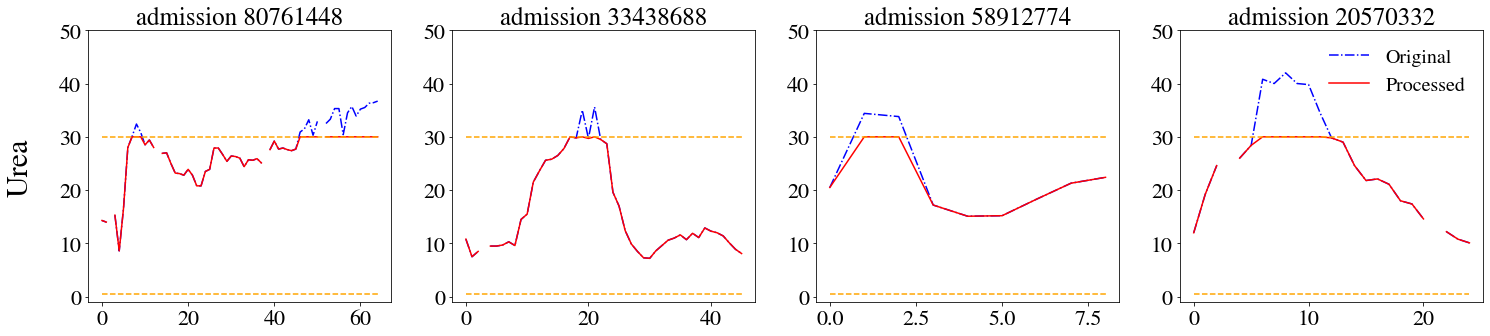

K
Values na in K 8591
Number of admissions that will change: 540
Number of records out of limits: 611
Percentage of admins modified for K from 13931 is 3.88 %
Percentage of records modified for K from 126048 is 0.48 %


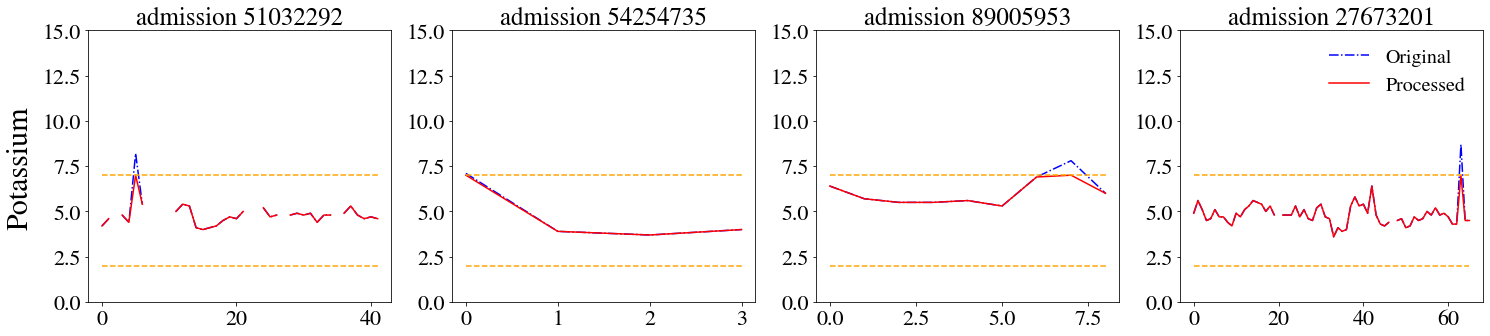

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


EGFR
Values na in EGFR 96270
Number of admissions that will change: 368
Number of records out of limits: 2739
Percentage of admins modified for EGFR from 13931 is 2.64 %
Percentage of records modified for EGFR from 126048 is 2.17 %


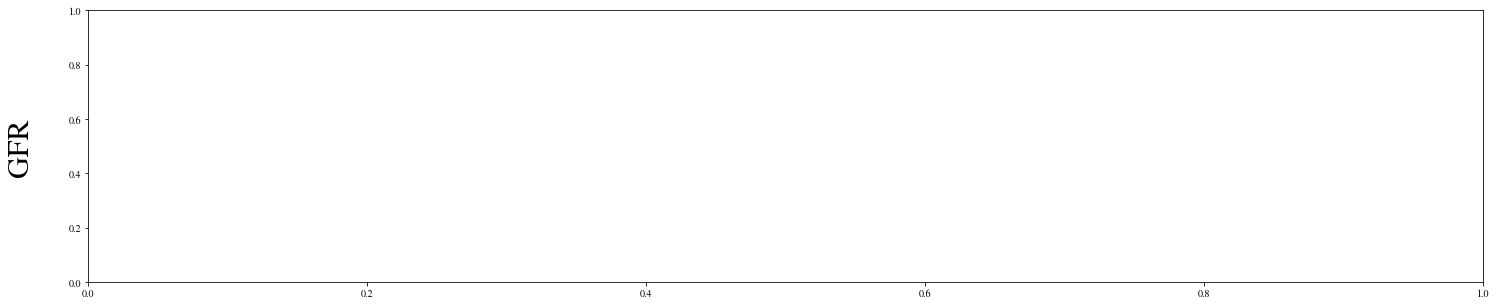

GFR
Values na in GFR 9139
Number of admissions that will change: 1086
Number of records out of limits: 9086
Percentage of admins modified for GFR from 13931 is 7.80 %
Percentage of records modified for GFR from 126048 is 7.21 %


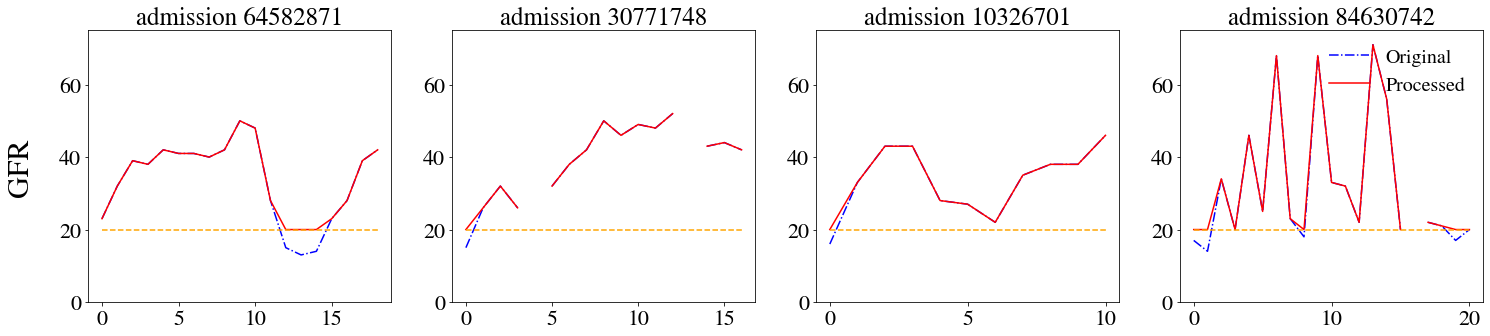

WBC
Values na in WBC 14936
Number of admissions that will change: 629
Number of records out of limits: 2698
Percentage of admins modified for WBC from 13931 is 4.52 %
Percentage of records modified for WBC from 126048 is 2.14 %


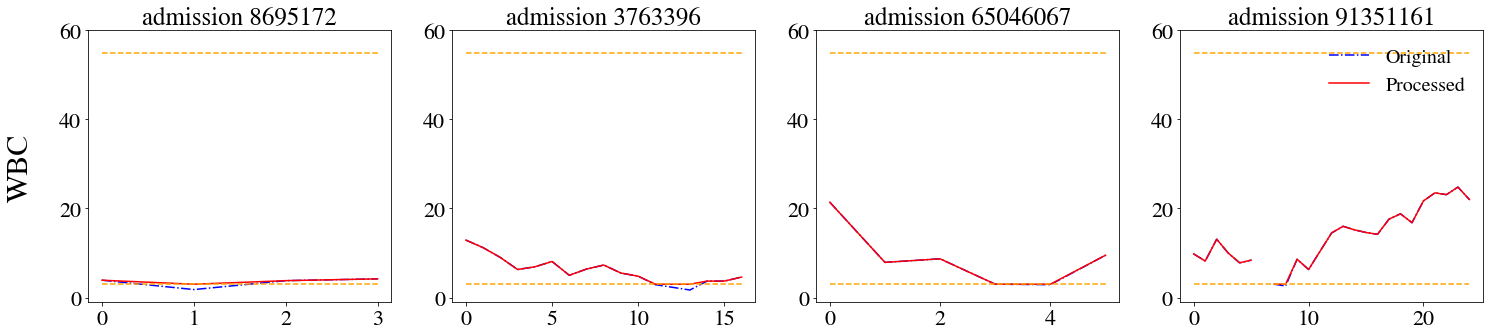

PLT
Values na in PLT 15239
Number of admissions that will change: 1454
Number of records out of limits: 7812
Percentage of admins modified for PLT from 13931 is 10.44 %
Percentage of records modified for PLT from 126048 is 6.20 %


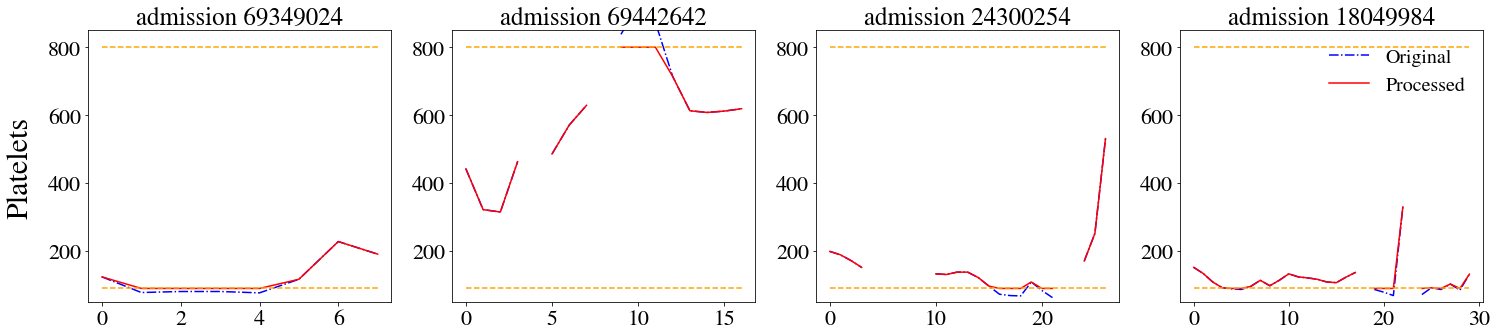

HCT
Values na in HCT 14920
Number of admissions that will change: 347
Number of records out of limits: 651
Percentage of admins modified for HCT from 13931 is 2.49 %
Percentage of records modified for HCT from 126048 is 0.52 %


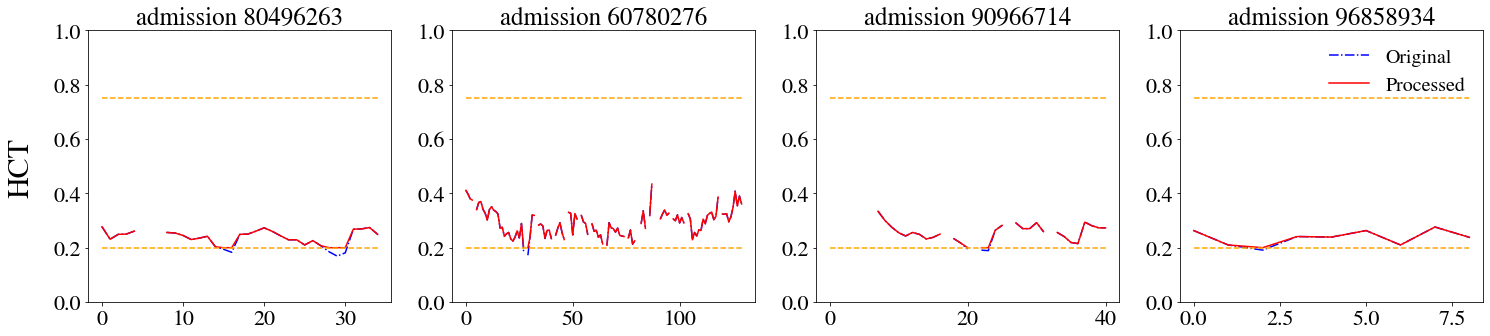

HGB
Values na in HGB 14920
Number of admissions that will change: 624
Number of records out of limits: 1282
Percentage of admins modified for HGB from 13931 is 4.48 %
Percentage of records modified for HGB from 126048 is 1.02 %


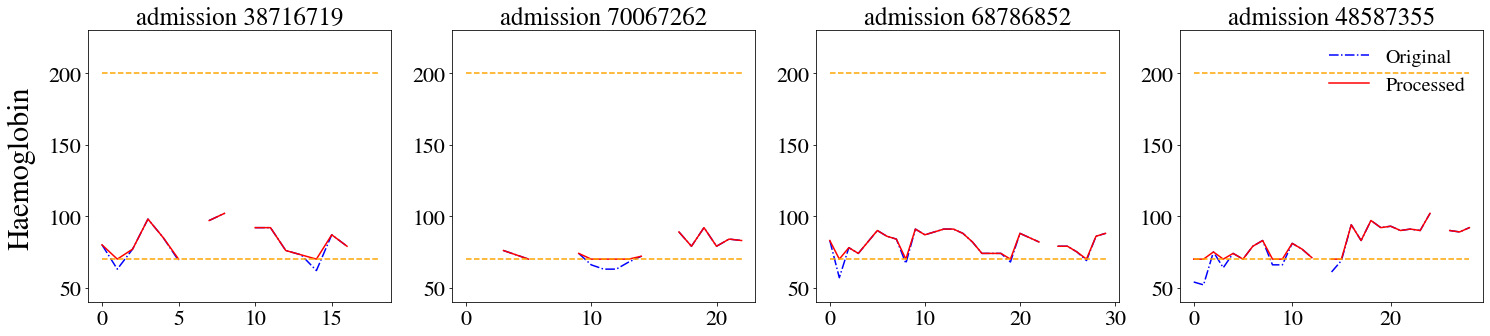

RBC
Values na in RBC 14921
Number of admissions that will change: 211
Number of records out of limits: 441
Percentage of admins modified for RBC from 13931 is 1.51 %
Percentage of records modified for RBC from 126048 is 0.35 %


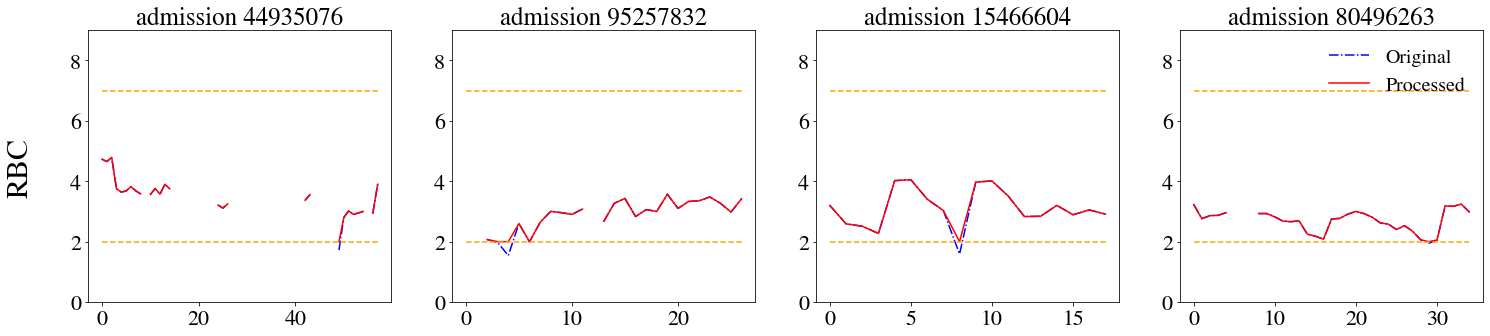

MCH
Values na in MCH 14920
Number of admissions that will change: 139
Number of records out of limits: 616
Percentage of admins modified for MCH from 13931 is 1.00 %
Percentage of records modified for MCH from 126048 is 0.49 %


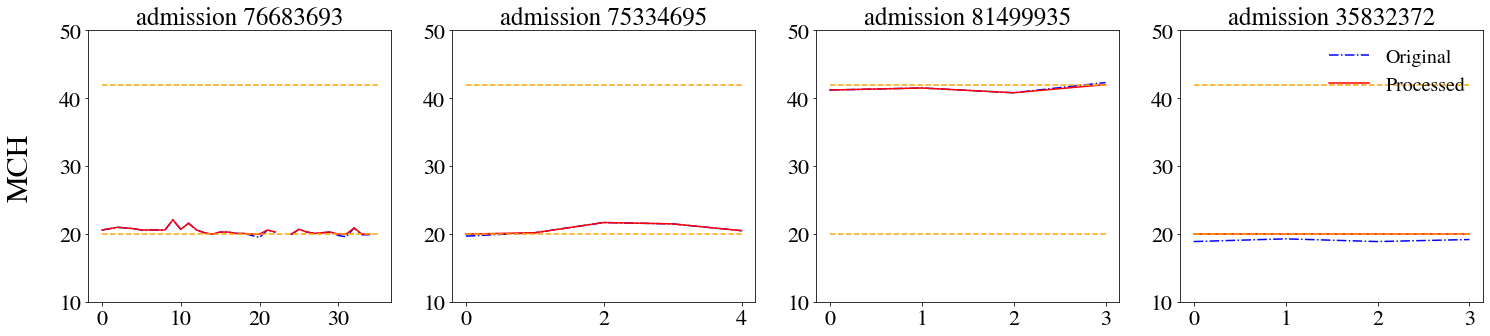

MCV
Values na in MCV 15064
Number of admissions that will change: 246
Number of records out of limits: 1189
Percentage of admins modified for MCV from 13931 is 1.77 %
Percentage of records modified for MCV from 126048 is 0.94 %


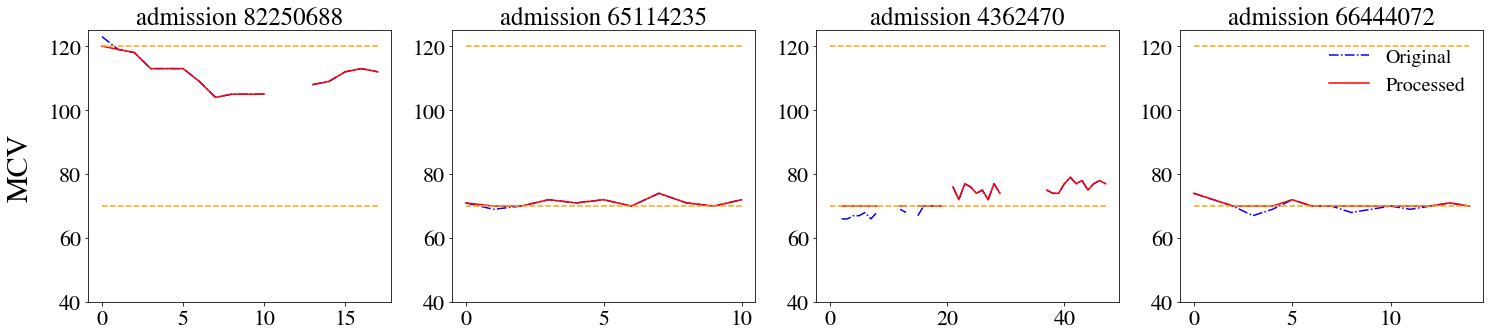

NEUAB
Values na in NEUAB 18739
Number of admissions that will change: 1632
Number of records out of limits: 3558
Percentage of admins modified for NEUAB from 13931 is 11.71 %
Percentage of records modified for NEUAB from 126048 is 2.82 %


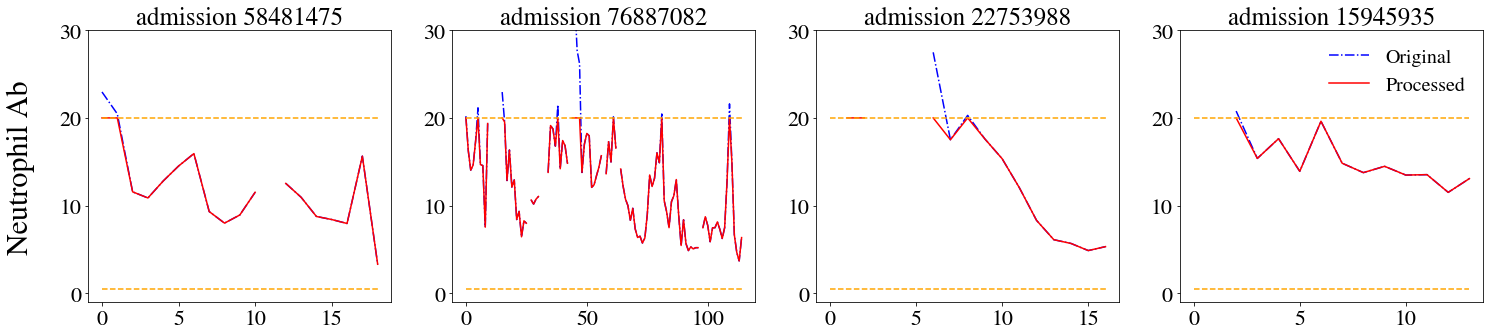

TLYMAB
Values na in TLYMAB 18754
Number of admissions that will change: 903
Number of records out of limits: 2497
Percentage of admins modified for TLYMAB from 13931 is 6.48 %
Percentage of records modified for TLYMAB from 126048 is 1.98 %


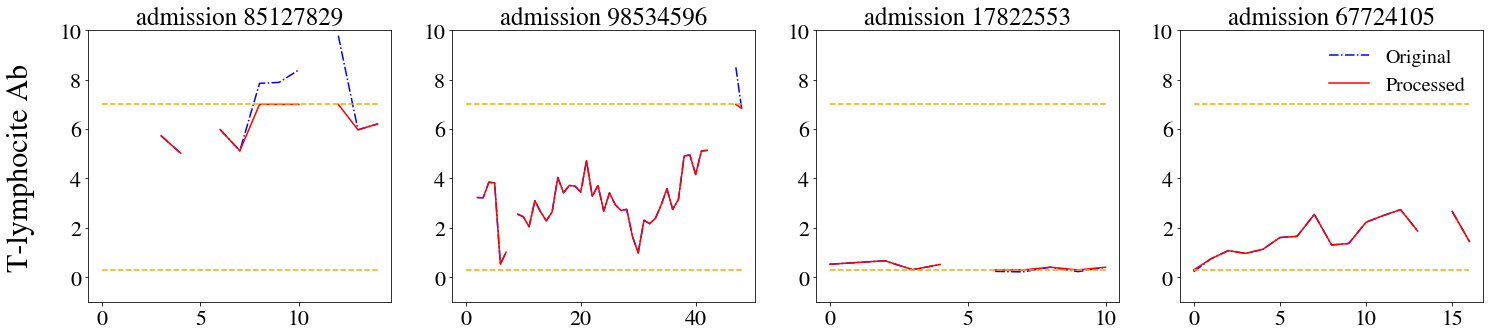

EOSAB
Values na in EOSAB 18753
Number of admissions that will change: 108
Number of records out of limits: 307
Percentage of admins modified for EOSAB from 13931 is 0.78 %
Percentage of records modified for EOSAB from 126048 is 0.24 %


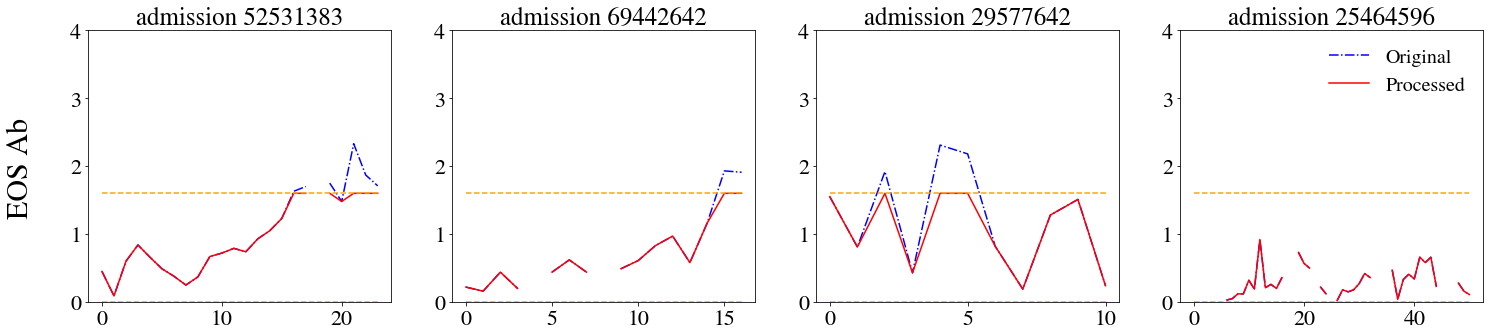

MONAB
Values na in MONAB 18770
Number of admissions that will change: 105
Number of records out of limits: 308
Percentage of admins modified for MONAB from 13931 is 0.75 %
Percentage of records modified for MONAB from 126048 is 0.24 %


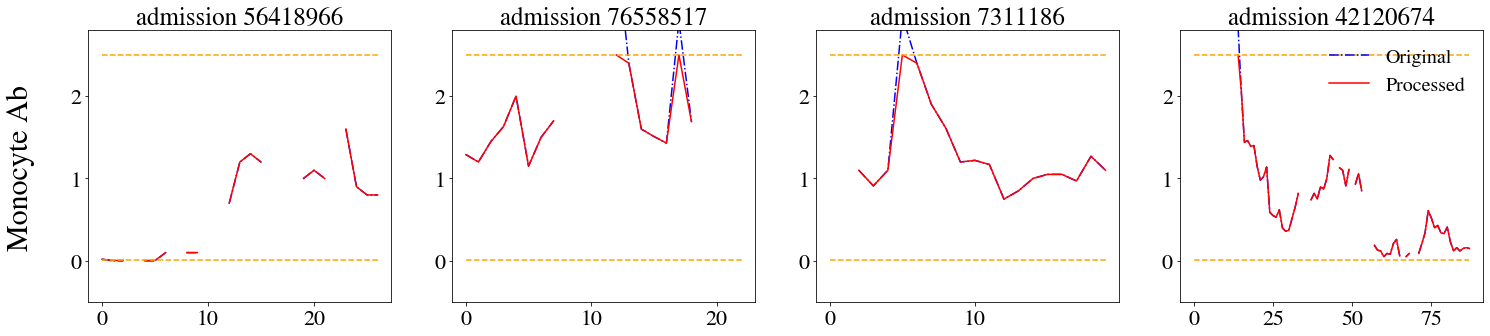

BASAB
Values na in BASAB 18865
Number of admissions that will change: 33
Number of records out of limits: 45
Percentage of admins modified for BASAB from 13931 is 0.24 %
Percentage of records modified for BASAB from 126048 is 0.04 %


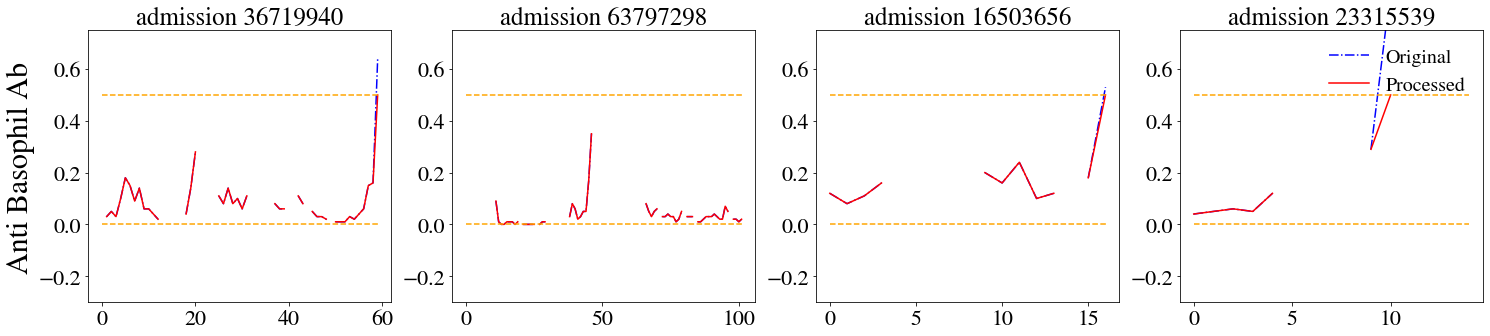

ALB
Values na in ALB 43924
Number of admissions that will change: 302
Number of records out of limits: 1043
Percentage of admins modified for ALB from 13931 is 2.17 %
Percentage of records modified for ALB from 126048 is 0.83 %


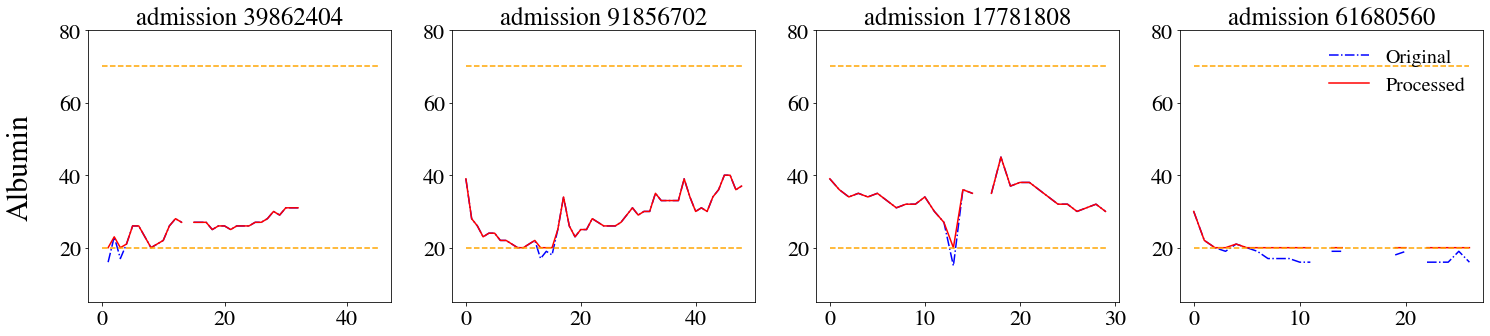

ALP
Values na in ALP 44255
Number of admissions that will change: 761
Number of records out of limits: 4181
Percentage of admins modified for ALP from 13931 is 5.46 %
Percentage of records modified for ALP from 126048 is 3.32 %


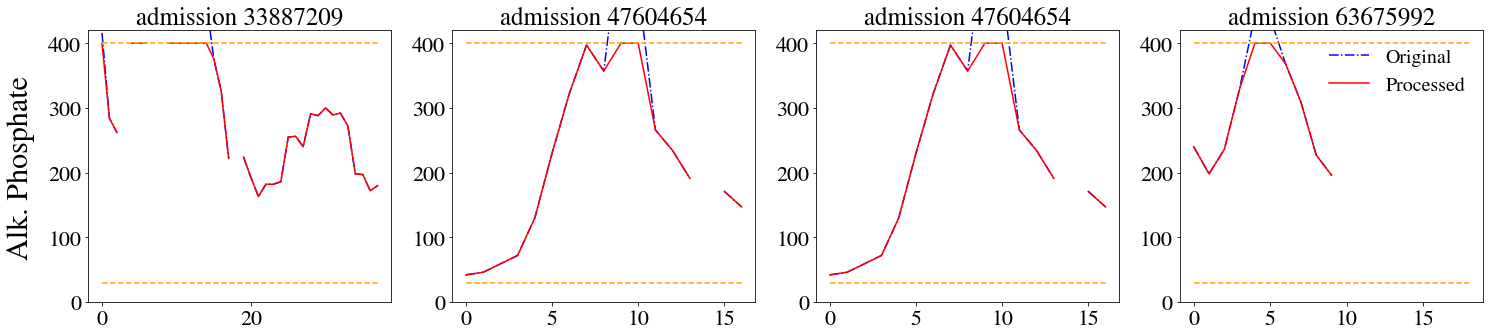

BILI
Values na in BILI 51577
Number of admissions that will change: 545
Number of records out of limits: 3152
Percentage of admins modified for BILI from 13931 is 3.91 %
Percentage of records modified for BILI from 126048 is 2.50 %


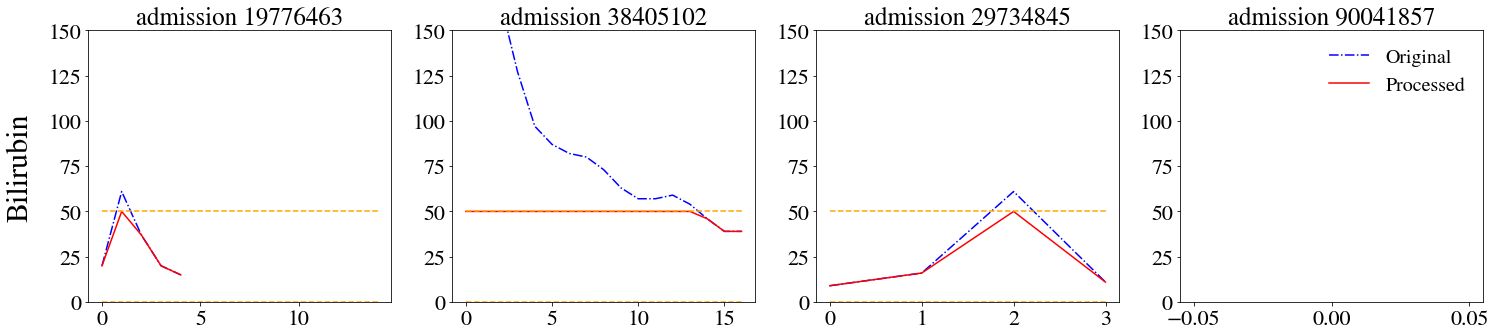

In [43]:
df_haematology_new_v2_n = df_haematology_new_v2[['admission_id','sample_collection_date_time'] +
                                                list(dict_blood_min_max.keys())].copy()
for feat in dict_blood_min_max.keys():
    df_haematology_new_v2_n = handling_errors(feat, df_haematology_new_v2_n, dict_blood_min_max, save = True)

In [45]:
display(df_haematology_new_v2[dict_blood_min_max.keys()].describe())
display(df_haematology_new_v2_n[dict_blood_min_max.keys()].describe())

,CREA,UREA,K,EGFR,GFR,WBC,PLT,HCT,HGB,RBC,MCH,MCV,NEUAB,TLYMAB,EOSAB,MONAB,BASAB,ALB,ALP,BILI
count,117935.000000,117915.000000,117457.000000,29778.000000,116909.000000,111112.000000,110809.000000,111128.000000,111128.000000,111127.000000,111128.000000,110984.000000,107309.000000,107294.000000,107295.000000,107278.000000,107183.000000,82124.000000,81793.000000,74471.000000
mean,114.665813,10.141332,4.301284,64.081915,67.232607,10.946071,292.102320,0.334119,108.728970,3.730430,29.332861,90.115017,8.452608,1.345139,0.170077,0.619920,0.040962,33.014247,151.456176,17.022654
std,117.989146,7.795807,0.750355,27.104416,26.713676,7.690132,161.134399,0.061316,20.293991,0.719118,2.850754,7.707438,4.861559,1.801161,0.224254,0.480131,0.085024,6.128041,176.618224,40.657780
min,19.998500,0.498500,1.600000,2.000000,2.000000,0.000000,2.000000,0.066000,1.000000,0.740000,12.700000,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,1.998500
25%,55.000000,5.100000,3.800000,42.000000,47.000000,7.100000,184.000000,0.290000,94.000000,3.220000,27.800000,86.000000,5.140000,0.800000,0.040000,0.400000,0.020000,29.000000,77.000000,6.000000
50%,78.000000,7.700000,4.300000,74.000000,79.000000,9.700000,265.000000,0.330000,107.000000,3.690000,29.500000,90.000000,7.430000,1.160000,0.110000,0.570000,0.030000,33.000000,104.000000,9.000000
75%,121.000000,12.400000,4.700000,90.001500,90.001500,13.100000,369.000000,0.374000,122.000000,4.200000,31.000000,94.000000,10.610000,1.630000,0.220000,0.780000,0.050000,37.000000,158.000000,15.000000
max,2247.000000,114.800000,18.600000,90.001500,342.000000,531.500000,2123.000000,1.000000,228.000000,8.130000,46.200000,142.000000,98.560000,391.700000,10.980000,76.020000,21.960000,66.000000,6790.000000,902.000000


,CREA,UREA,K,EGFR,GFR,WBC,PLT,HCT,HGB,RBC,MCH,MCV,NEUAB,TLYMAB,EOSAB,MONAB,BASAB,ALB,ALP,BILI
count,117935.000000,117915.000000,117457.000000,29778.000000,116909.000000,111112.000000,110809.000000,111128.000000,111128.000000,111127.000000,111128.000000,110984.000000,107309.000000,107294.000000,107295.000000,107278.000000,107183.000000,82124.000000,81793.000000,74471.000000
mean,112.541917,9.879054,4.294688,64.827935,67.810757,10.874304,292.799348,0.334234,108.808509,3.731193,29.337084,90.150769,8.317786,1.311155,0.167798,0.616862,0.040419,33.046442,135.339736,12.575769
std,105.167408,6.759580,0.713370,25.700732,25.463129,5.926947,151.153038,0.061000,20.106030,0.716639,2.824647,7.518055,4.339520,0.774099,0.196652,0.315838,0.035373,6.048633,89.729574,11.209675
min,20.000000,0.500000,2.000000,20.000000,20.000000,3.000000,90.000000,0.200000,70.000000,2.000000,20.000000,70.000000,0.500000,0.300000,0.000000,0.005000,0.000000,20.000000,30.000000,1.998500
25%,55.000000,5.100000,3.800000,42.000000,47.000000,7.100000,184.000000,0.290000,94.000000,3.220000,27.800000,86.000000,5.140000,0.800000,0.040000,0.400000,0.020000,29.000000,77.000000,6.000000
50%,78.000000,7.700000,4.300000,74.000000,79.000000,9.700000,265.000000,0.330000,107.000000,3.690000,29.500000,90.000000,7.430000,1.160000,0.110000,0.570000,0.030000,33.000000,104.000000,9.000000
75%,121.000000,12.400000,4.700000,90.001500,90.001500,13.100000,369.000000,0.374000,122.000000,4.200000,31.000000,94.000000,10.610000,1.630000,0.220000,0.780000,0.050000,37.000000,158.000000,15.000000
max,600.000000,30.000000,7.000000,90.001500,200.000000,55.000000,800.000000,0.750000,200.000000,7.000000,42.000000,120.000000,20.000000,7.000000,1.600000,2.500000,0.500000,66.000000,400.000000,50.000000


In [46]:
df_haematology_new_v2_n.head(4)

,admission_id,sample_collection_date_time,CREA,UREA,K,EGFR,GFR,WBC,PLT,HCT,...,MCH,MCV,NEUAB,TLYMAB,EOSAB,MONAB,BASAB,ALB,ALP,BILI
0,30861976,2018-04-08 15:54:00,67.0,11.8,4.0,NaN,78.0000,12.0,416.0,0.200,...,20.0,70.0,NaN,NaN,NaN,NaN,NaN,36.0,70.0,8.0
1,30861976,2018-04-09 06:54:00,46.0,15.1,4.3,NaN,90.0015,14.5,294.0,0.370,...,21.4,72.0,13.76,0.37,0.01,0.27,0.08,NaN,NaN,NaN
2,30861976,2018-04-10 09:08:00,34.0,12.9,4.0,NaN,90.0015,18.5,261.0,0.335,...,22.2,73.0,17.76,0.42,0.00,0.30,0.03,25.0,81.0,13.0
3,30861976,2018-04-11 09:12:00,25.0,8.4,3.6,NaN,90.0015,21.6,225.0,0.316,...,22.5,73.0,20.00,0.51,0.02,0.55,0.02,26.0,102.0,11.0


In [47]:
print("number of features in heamatology",len(df_haematology_new_v2_n.columns))
display(df_haematology_new_v2_n.columns)

number of features in heamatology 22


Index(['admission_id', 'sample_collection_date_time', 'CREA', 'UREA', 'K',
       'EGFR', 'GFR', 'WBC', 'PLT', 'HCT', 'HGB', 'RBC', 'MCH', 'MCV', 'NEUAB',
       'TLYMAB', 'EOSAB', 'MONAB', 'BASAB', 'ALB', 'ALP', 'BILI'],
      dtype='object')

# 6. Looking at null and type values

In [48]:
df = pd.concat([df_haematology_new_v2_n.isna().sum(), df_haematology_new_v2_n.dtypes], axis=1)
df = df.rename(columns ={0:'nulls',1:'type'})
display(df.sort_values(by=['nulls']))

,nulls,type
admission_id,0,int64
sample_collection_date_time,0,datetime64[ns]
CREA,8113,float64
UREA,8133,float64
K,8591,float64
GFR,9139,float64
MCH,14920,float64
HCT,14920,float64
HGB,14920,float64
RBC,14921,float64


# 7. Placing number of blood test in admissions dataframe

In [49]:
t = time.time()
admin_obs = []
for adm in df_admissions[admission_field]:    
    admin_obs.append(len(df_haematology_new_v2_n[df_haematology_new_v2_n[admission_field] == adm]))
df_admissions.loc[:,no_haematology_field] = admin_obs
print("number of admissions", len(df_admissions))
print('times elapsed, during adding no_heamatology_field: ',time.time() - t)
df_admissions.head(4)

number of admissions 18537
times elapsed, during adding no_heamatology_field:  8.599147081375122


,admission_id,episode_diagnoses,patient_id,age_at_admission\r,admission_date_time,admission_date_code_time,discharge_date_time,discharge_date_code_time,lengthofstay,isPneumonia,mortal_admin,icu_count\r,Comorbidity_score,no_obs_eobs,no_haematology_eobs
1,7763466,"||J18.1,J84.9,C34.9,R26.8,E11.9,R15.X,R32.X,H91.9",68825097,90,2017-10-26 05:36:00,17465.233333,2017-10-26 17:59:00,17465.749306,0 days 12:23:00,1,0,0,3,10,0
2,58250780,"||J18.1,J44.0,C34.9,I71.4,R60.0,I73.9,Z92.1,I1...",68825097,91,2017-11-06 23:01:00,17476.959028,2017-11-09 05:50:00,17479.243056,2 days 06:49:00,1,1,0,15,20,0
4,92464775,"||J18.1,N17.9,F05.9,J90.X,R33.X,G20.X,R63.8,E1...",18544317,91,2018-03-11 18:20:00,17601.763889,2018-03-16 18:00:00,17606.750000,4 days 23:40:00,1,1,0,6,45,1
5,74554266,"||J18.9,E87.1,A09.0,R11.X,I10.X,M10.9,C91.1,F3...",42309321,72,2018-02-19 07:58:00,17581.331944,2018-02-23 18:00:00,17585.750000,4 days 10:02:00,1,0,0,0,17,6


# 8. Pickling Data

In [50]:
pickling_data = [df_patients, df_admissions]
pickle.dump(pickling_data, open('DataFrame_pickles/df_patients_admissions_v3.pickle', 'wb'))
pickling_data = [df_haematology_new_v2_n]
pickle.dump(pickling_data, open('DataFrame_pickles/df_haematology_v1.pickle', 'wb'))

# Look at reference ranges

In [ ]:
list_codes = ['CREA', 'UREA', 'K', 'GFR', 'WBC', 'PLT', 'HCT', 'MCH', 'RBC', 'MCV',
       'NRBCAD', 'NEUAB', 'TLYMAB', 'MONAB', 'EOSAB', 'BASAB', 'HGB', 'ALB',
       'ALP', 'ALT', 'BILI', 'AKIDUM', 'CRP']
list_codes = ['CREA','UREA','K','EGFR','GFR','WBC','AKIDUM','PLT','HCT','HGB','RBC','MCH','MCV','NRBCAD','NEUAB',
              'TLYMAB' ,'EOSAB', 'MONAB','BASAB','CRP','ALB','ALP','BILI' ,'ALT','TP','PHOS','ACA','CG','INR','CA',
              'MG','PT']
for code in list_codes:
    ranges = df_haemt[df_haemt['local_test_code'] == code]['refererence_range'].unique().tolist()
    units_ = df_haemt[df_haemt['local_test_code'] == code]['units'].unique().tolist()
    print(code)
    print(ranges)
    print(units_)
    print("")
    #break


